# Kurdish Deep Speech Recognizer

## Exploration

To start, let's explore the sound files that we have

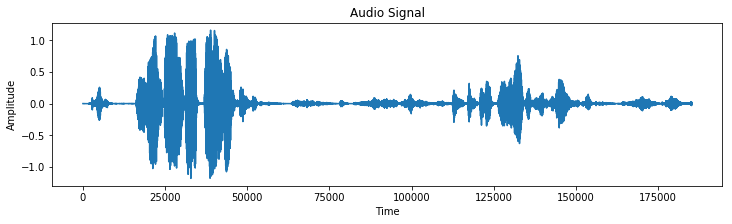

**Shape of Audio Signal** : (185220,)

**Transcript** : nûpelda parlaq

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

## Feature representation

We use MFCC to represent audio features as vectors instead of raw audio

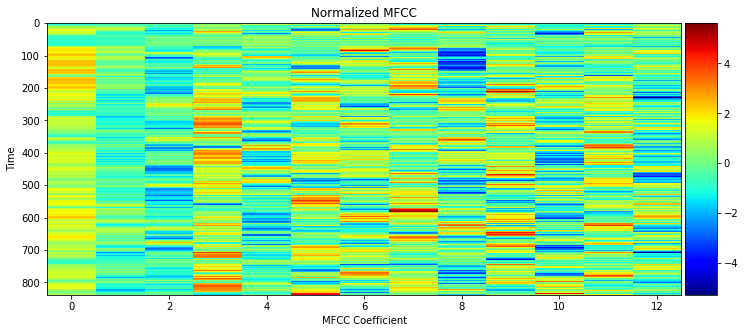

**Shape of MFCC** : (839, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

A setup code that can be run to reload the sample models from the sample_models and the training utilities from the train_utils file

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model

Initialize the model

In [8]:
# specify the model
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_birnn (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

### Model training

Train the model and save it as model_end.h5

In [9]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
127/127 [==============================] - 606s 5s/step - loss: 154.2394 - val_loss: 106.1272
Epoch 2/20
127/127 [==============================] - 569s 4s/step - loss: 83.7908 - val_loss: 77.4269
Epoch 3/20
127/127 [==============================] - 552s 4s/step - loss: 63.7763 - val_loss: 69.6263
Epoch 4/20
127/127 [==============================] - 550s 4s/step - loss: 53.4994 - val_loss: 56.7148
Epoch 5/20
127/127 [==============================] - 525s 4s/step - loss: 47.4312 - val_loss: 52.4009
Epoch 6/20
127/127 [==============================] - 519s 4s/step - loss: 43.0651 - val_loss: 49.6200
Epoch 7/20
127/127 [==============================] - 517s 4s/step - loss: 40.1588 - val_loss: 49.1288
Epoch 8/20
127/127 [==============================] - 517s 4s/step - loss: 37.5964 - val_loss: 49.5587
Epoch 9/20
127/127 [==============================] - 518s 4s/step - loss: 34.9503 - val_loss: 44.4436
Epoch 10/20
127/127 [==============================] - 518s 4s/step - l

Run the next cell to visualize the training vs validation loss. It is clear that there was alot of overfitting but I didn't have access to a GPU here so I'll leave it for now.

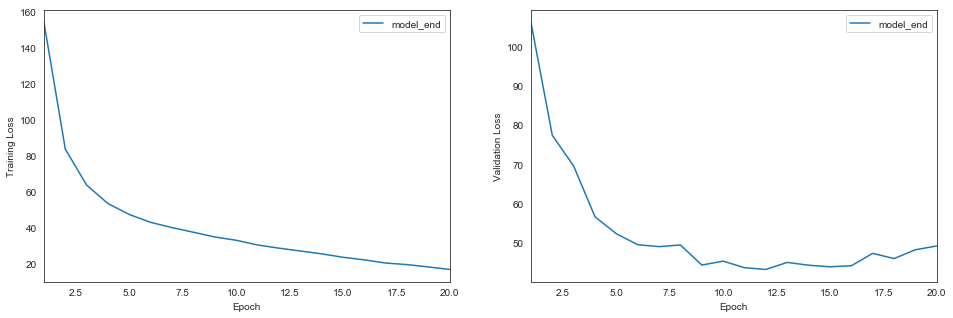

In [32]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

## Predictions

This function decodes predictions into readable text

In [10]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

## Results

Those following cells show predictions for specific files in the training and validation sets

In [22]:
get_predictions(index=2,
                partition='train',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 400)         481200    
_________________________________________________________________
bn_birnn (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

In [16]:
get_predictions(index=0,
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_birnn (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

In [20]:
get_predictions(index=3,
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 400)         481200    
_________________________________________________________________
bn_birnn (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

In [30]:
get_predictions(index=103,
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_35 (Bidirectio (None, None, 400)         481200    
_________________________________________________________________
bn_birnn (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________